In [12]:
import aerosandbox as asb
import aerosandbox.numpy as np
import pandas as pd
from aerosandbox.tools.pretty_plots import plt, show_plot

In [13]:
data = pd.read_csv("Fig_from_incompressible_flow_wiley.csv")
log10_Re = data["x"].values
log10_Cd = data["Data"].values
Re = 10 ** log10_Re
Cd = 10 ** log10_Cd

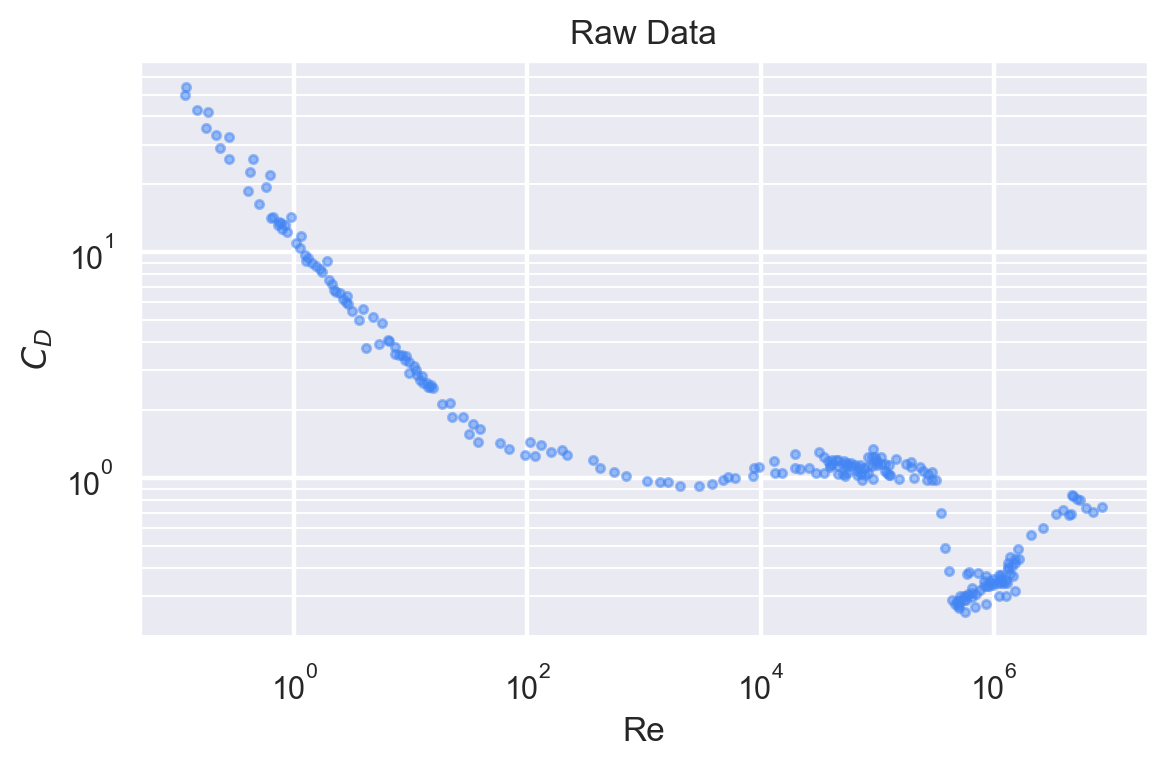

In [14]:
fig, ax = plt.subplots()
plt.loglog(
    Re,
    Cd,
    ".",
    alpha=0.5
)
show_plot("Raw Data", "Re", "$C_D$")

Isolate the sub- and supercritical data:

In [15]:
Re_sub = Re[Re < 200e3]
Cd_sub = Cd[Re < 200e3]
Re_sup = Re[Re > 600e3]
Cd_sup = Cd[Re > 600e3]

Do the subcritical fit:

{'csub0': -0.6673242107867435, 'csub1': 1.0417842536568518, 'csub2': 0.5420892838073137, 'csub3': 0.1202699487648455}


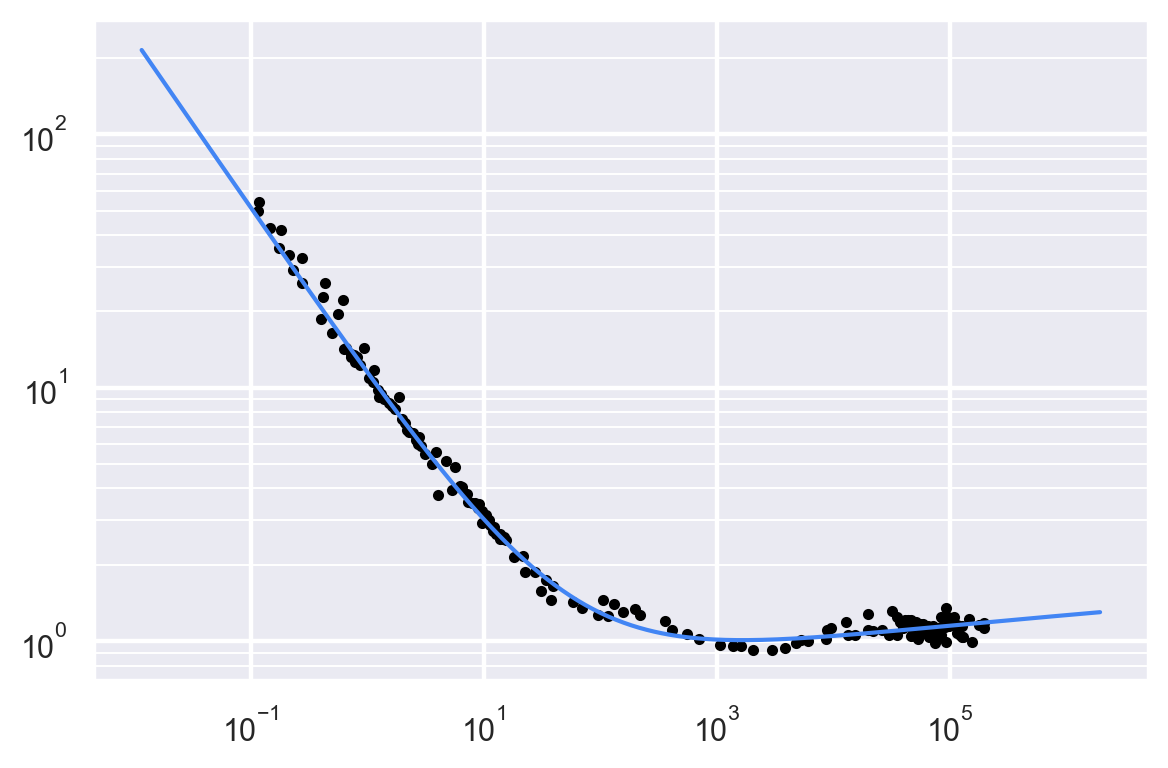

In [16]:
fit_sub = asb.FittedModel(
    model=lambda x, p: 10 ** (p["csub0"] * np.log10(x) + p["csub1"]) + p["csub2"] + p["csub3"] * np.log10(x),
    x_data=Re_sub,
    y_data=Cd_sub,
    parameter_guesses={
        "csub0": -0.7,
        "csub1": 1,
        "csub2": 0.67,
        "csub3": 0.1,
    },
    parameter_bounds={
        "csub2": (1e-6, None),
        "csub3": (0, None)
    },
    put_residuals_in_logspace=True,
    residual_norm_type="L1",
    verbose=False
)
print(fit_sub.parameters)
fig, ax = plt.subplots()
plt.loglog(Re_sub, Cd_sub, ".k")
Res = np.geomspace(Re_sub.min() / 10, Re_sub.max() * 10, 500)
plt.plot(Res, fit_sub(Res), "-")
show_plot()

Do the supercritical fit:

{'csup0': -0.11999999011467052, 'csupc': 6.688101936003553, 'csuph': 10.000000088931557, 'csupscl': -0.47937484049312823}


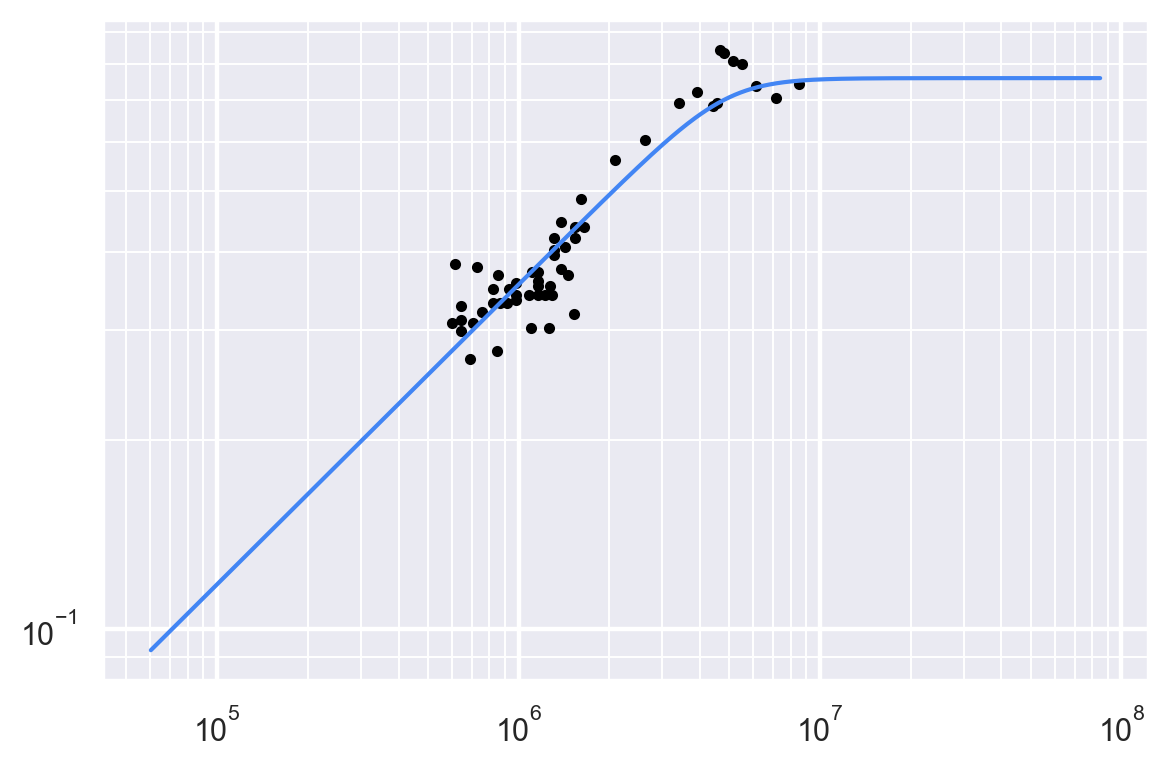

In [17]:
fit_sup = asb.FittedModel(
    model=lambda x, p: 10 ** (
            p["csup0"] + p["csupscl"] / p["csuph"] * np.log(np.exp(p["csuph"] * (p["csupc"] - np.log10(x))) + 1)),
    x_data=Re_sup,
    y_data=Cd_sup,
    parameter_guesses={
        "csup0"  : -0.12,
        "csupc"  : 6.7,
        "csuph"  : 10,
        "csupscl": -0.5
    },
    parameter_bounds={
        "csup0": (-1, -0.12),
        "csupc": (6, 7),
        "csuph": (1e-6, 10),
    },
    put_residuals_in_logspace=True,
    residual_norm_type="L1",
    verbose=False
)
print(fit_sup.parameters)
fig, ax = plt.subplots()
plt.loglog(Re_sup, Cd_sup, ".k")
Res = np.geomspace(Re_sup.min() / 10, Re_sup.max() * 10, 500)
plt.plot(Res, fit_sup(Res), "-")
show_plot()

Now, blend them together:

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     5442
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      257
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      502
        inequality constraints with only lower bounds:        5
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      497

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

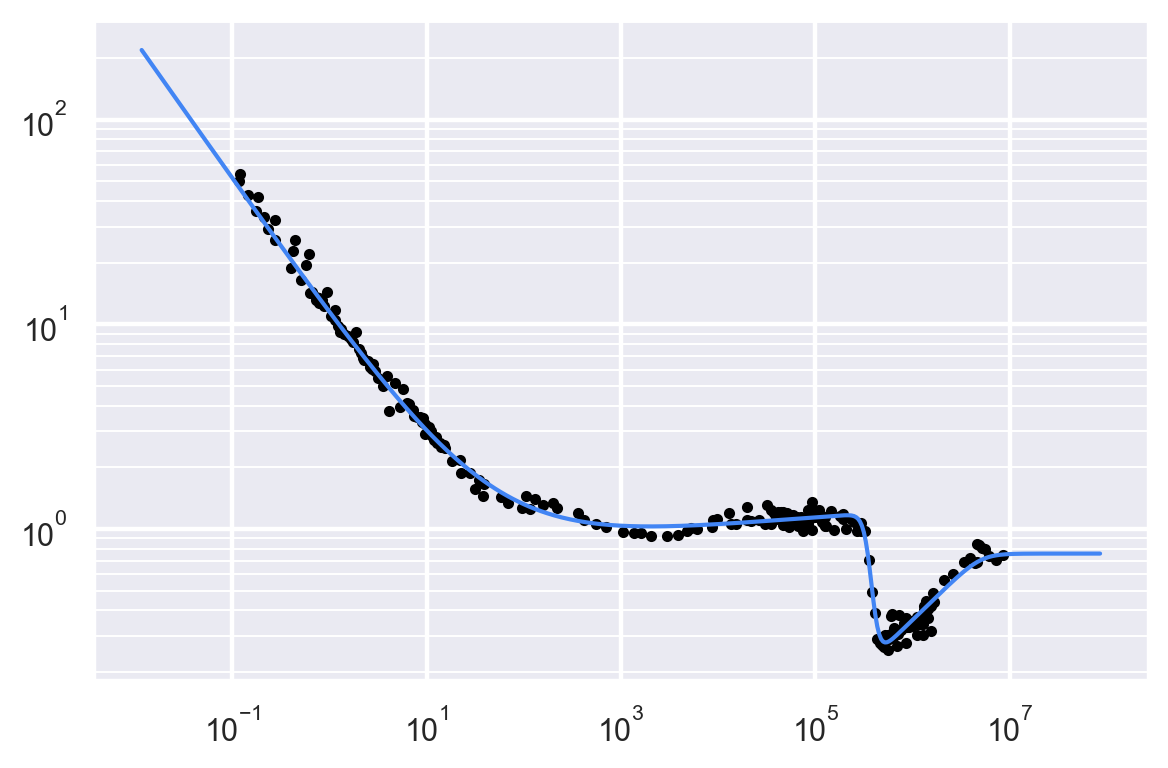

In [18]:
def model(x, p):
    lx = np.log10(x)

    Cd_subcrit = 10 ** (
            p["csub0"] * lx + p["csub1"]
    ) + p["csub2"] + p["csub3"] * lx

    Cd_supcrit = 10 ** (
            p["csup0"] + p["csupscl"] / p["csuph"] * np.softmax(p["csuph"] * (p["csupc"] - lx), 0)
    )

    return np.blend(
        p["csigh"] * (lx - p["csigc"]),
        Cd_supcrit,
        Cd_subcrit,
    )


fit = asb.FittedModel(
    model=model,
    x_data=Re,
    y_data=Cd,
    parameter_guesses={
        **fit_sub.parameters,
        **fit_sup.parameters,
        "csigh": 12,
        "csigc": 5.6,
    },
    parameter_bounds={
        **fit_sub.parameter_bounds,
        **fit_sup.parameter_bounds,
    },
    put_residuals_in_logspace=True,
    residual_norm_type="L1",
    # verbose=False
)
for k, v in fit.parameters.items():
    print(f"{k:8}: {v}")
fig, ax = plt.subplots()
plt.loglog(Re, Cd, ".k")
Res = np.geomspace(Re.min() / 10, Re.max() * 10, 500)
plt.plot(Res, fit(Res), "-")
show_plot()

Now, make a pretty plot:

NameError: name 'mpl' is not defined

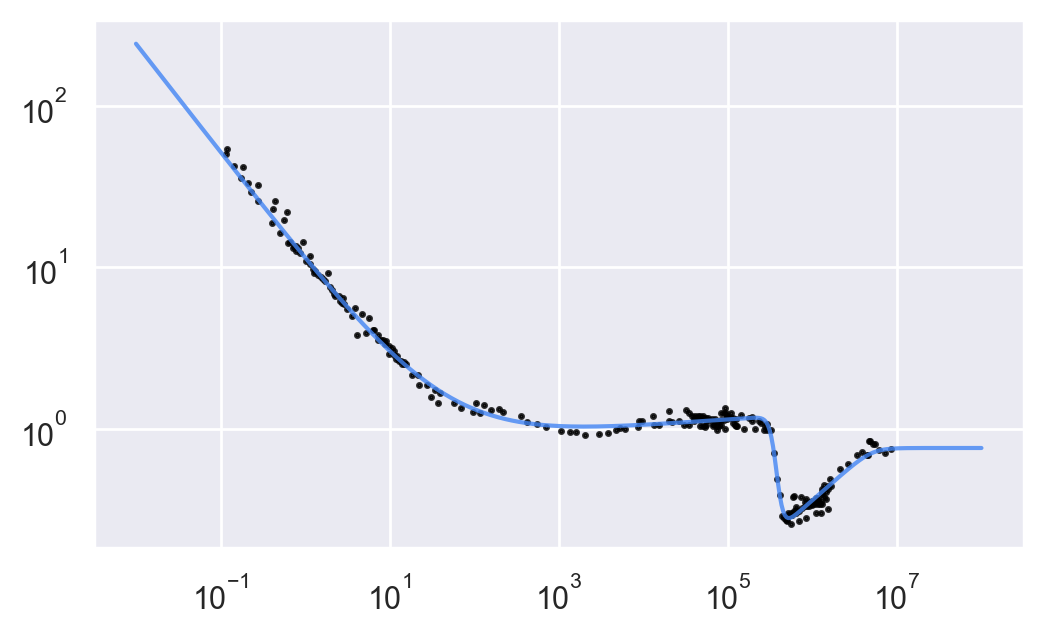

In [19]:
fig, ax = plt.subplots(figsize=(6, 3.5))
plt.loglog(Re, Cd,
           ".k",
           markersize=3,
           alpha=0.8,
           label="Data"
           )
Res = np.geomspace(1e-2, 1e8, 500)
plt.plot(Res, fit(Res),
         "-",
         alpha=0.8,
         label="Fitted Model"
         )
ax.xaxis.set_major_locator(mpl.ticker.LogLocator(numticks=15))
ax.xaxis.set_minor_locator(mpl.ticker.LogLocator(subs='all', numticks=300))
plt.xlim(1e-1 * 10 ** -0.5, 1e7 * 10 ** 0.5)
plt.ylim(1e-1, 1e2)
plt.annotate(
    text="Data from Panton: Incompressible Flow (4th Ed.)",
    xy=(0.02, 0.02),
    xycoords="axes fraction",
    ha="left",
    fontsize=9,
    alpha=0.5
)

show_plot(
    "Cylinder Drag Coefficient",
    r"Reynolds Number $\mathrm{Re}_D$",
    r"Drag Coefficient $C_D$",
    show=False,
)
# plt.savefig(r"C:\Users\User\Dropbox (MIT)\School\Grad School\2021 Spring\Thesis\TeX\figures\cylinder-drag-fitting.pgf")
plt.show()